## Загрузим нужные библиотеки

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
from google.colab import drive, files
drive.mount('/content/drive')
!pip install catboost
import catboost as cb
from sklearn.metrics import recall_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/karelia/train.csv') # данные пользователя
df_sample_solution = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/karelia/sample_solution.csv') 
df_named = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/karelia/named.csv') #лог днс-запросов к доменам конкурентов (rt.ru и sampo.ru)
df_type_contract = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/karelia/type_contract.csv') #тип списания у пользователей
df_log = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/karelia/log.csv') #содержит данные обращения пользователей


## Рассмотрим датасет по ближе

In [ ]:
df_train.head(3)

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   contract_id  5992 non-null   int64
 1   blocked      5992 non-null   int64
dtypes: int64(2)
memory usage: 93.8 KB


In [ ]:
df_train.blocked.value_counts()

0    5294
1     698
Name: blocked, dtype: int64

In [ ]:
df_named.head(3)

,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335


In [ ]:
df_named.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10646537 entries, 0 to 10646536
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   date         object
 1   url          object
 2   contract_id  int64 
dtypes: int64(1), object(2)
memory usage: 243.7+ MB


In [ ]:
df_named.contract_id.value_counts()

14321    6934
31215    6902
12914    6632
27891    6491
54140    3675
         ... 
10363       1
31238       1
34688       1
51415       1
48679       1
Name: contract_id, Length: 196148, dtype: int64

In [ ]:
df_named.url.value_counts()

camera.rt.ru                                         7333195
vmxott.svc.iptv.rt.ru                                 289876
tvip-provision.sampo.ru                               138944
webmail.sampo.ru                                      132718
statserv.sampo.ru                                     110428
                                                      ...   
_bittorrent-tracker._tcp.ip94-143-246-20.sampo.ru          1
_bittorrent-tracker._tcp.ip212-109-29-44.sampo.ru          1
jcyzowodsk.sampo.ru                                        1
dhmisszt.sampo.ru                                          1
broadband-90-154-70-112.ip.moscow.rt.ru                    1
Name: url, Length: 6583, dtype: int64

In [ ]:
df_log.head(5)

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах


In [ ]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25274 entries, 0 to 25273
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   contract_id  25274 non-null  int64 
 1   event_date   25274 non-null  object
 2   event_type   25274 non-null  object
dtypes: int64(1), object(2)
memory usage: 592.5+ KB


In [ ]:
df_log.event_type.value_counts()

Информер ВК. Показ                                                  8001
Включение интернета на 20 минут                                     4092
Обращение в службу заботы о клиентах                                2860
Гарантированный платеж за деньги                                    2679
Виртуальное бессмертие. Использование                                757
                                                                    ... 
Футболка Ситилинк                                                      1
Закрытие информатора об изменении уведомлений через ВК платформу       1
Окончание рассрочки за подключение                                     1
Общий счет. Отсоединение реципиента                                    1
Общий счет. Отсоединение от донора                                     1
Name: event_type, Length: 105, dtype: int64

In [ ]:
df_type_contract.head(3)

,contract_id,day_or_month_contract
0,7780,0
1,3996,0
2,7785,0


In [ ]:
df_sample_solution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   contract_id  810 non-null    int64
 1   blocked      810 non-null    int64
dtypes: int64(2)
memory usage: 12.8 KB


In [11]:
df_named['date'] = pd.to_datetime(df_named['date'])

In [12]:
last_conc = df_named.groupby('contract_id').agg('last')

In [13]:
df_log['event_date'] = pd.to_datetime(df_log['event_date'])

In [14]:
last_support = df_named.groupby('contract_id').agg('last')

In [15]:
last_support

,date,url
contract_id,,
3455,2021-04-09,cnt-odcv-itv03.svc.iptv.rt.ru
3458,2021-04-20,fnc.rt.ru
3459,2021-04-28,petrozavodsk.speedtest.rt.ru.prod.hosts.ooklas...
3460,2021-03-31,file.sampo.ru
3461,2021-04-17,fnc.rt.ru
...,...,...
271820,2021-03-30,petrozavodsk.speedtest.rt.ru.prod.hosts.ooklas...
272061,2021-04-04,fnc.rt.ru
273472,2021-03-28,data.sampo.ru


## Объединение датасета

Обьединим два набора с данными

In [16]:
df_full = pd.merge(df_train, df_type_contract , on="contract_id", how='left').fillna(0)

## Feature engineering 

In [17]:
# количество обращений в службу поддержки
count_log = df_log.groupby("contract_id").count()
df_full = pd.merge(df_full, count_log , on="contract_id", how='left').drop(["event_date"],axis =1).rename(columns={'event_type':'num_of_calls'})

In [18]:
# количсевто обращений к конкурентам
count_named = df_named.groupby("contract_id").count()
df_full = pd.merge(df_full, count_named , on="contract_id", how='left').drop(["date"],axis =1).fillna(0).rename(columns={'url':'num_competitor_url'})

In [19]:
# меняю тип данных
df_full[['day_or_month_contract', 'num_of_calls', 'num_competitor_url']] = df_full[['day_or_month_contract', 'num_of_calls', 'num_competitor_url']].astype('int')

In [20]:
# последнее обращение в службу поддержки
last_log = df_log.groupby('contract_id').agg('last')
df_full = pd.merge(df_full, last_log , on="contract_id", how='left').drop(["event_date"],axis =1)

In [21]:
# Расчёт соотношения обращений к конкурентам на оДно обращение в службу поддержки
df_full['ev_url'] = df_full['num_competitor_url']  / df_full['num_of_calls']
df_full['ev_url'] = df_full['ev_url'].fillna(0)

In [22]:
# Расчёт соотношения обращений к конкурентам на оДно обращение в службу поддержки
df_full['ev_url'] = df_full['num_competitor_url']  / df_full['num_of_calls']
df_full['ev_url'] = df_full['ev_url'].fillna(0)

In [23]:
# расчитаю суммарное количество уникальных обращений в поддержку
n_un_log = df_log.groupby('contract_id')['event_type'].nunique()
df_full = pd.merge(df_full, n_un_log , on="contract_id", how='left').rename(columns={'event_type_y':'uniq_support_calls'})

In [24]:
# расчитаю суммарное количество уникальных обращений к конкурентам
n_un_url = df_named.groupby('contract_id')['url'].nunique()
df_full = pd.merge(df_full, n_un_url , on="contract_id", how='left').rename(columns={'url':'uniq_compet_calls'})

In [25]:
df_full = df_full.query('num_competitor_url<150')
df_full = df_full.query('num_of_calls<20')

In [ ]:
sns.pairplot( # матрица диаграмм рассеяния из Seaborn
data = df_full, # данные
hue = 'blocked', # имя столбца в данных для раскраски меток
corner = True # матрица симметрична, не будем выводить лишние графики
).fig.suptitle( # настройки заголовка
'Зависимости для признаков', # заголовок
y = 1.08 # расположение
);

In [26]:
p = pd.pivot_table(df_log, index = 'contract_id', columns = 'event_type', values = 'event_date', aggfunc='count')

In [27]:
df_full = pd.merge(df_full, p , on="contract_id", how='left')

In [28]:
df_full = df_full.fillna(0)

## Дисбаланс классов

In [142]:
disbalance = df_full.blocked.value_counts()
disbalance

0    5083
1     675
Name: blocked, dtype: int64

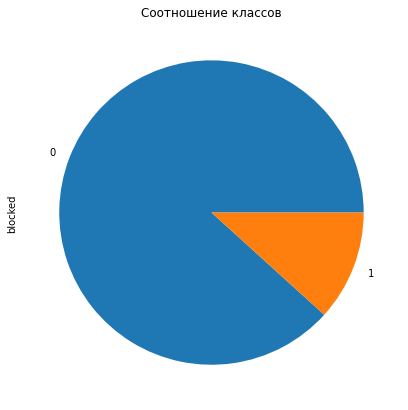

In [143]:
disbalance.plot(kind='pie',figsize = (7,7))
plt.title('Соотношение классов');

In [144]:
df_1 = df_full.loc[df_full['blocked']==1]
df_1 = df_1.loc[df_1.index.repeat(7)]
df_bal = pd.concat([df_full.loc[df_full['blocked']==0], df_1]).sample(frac=1)

In [145]:
df_bal.blocked.value_counts()

0    5083
1    4725
Name: blocked, dtype: int64

## Разделение на выборки

In [146]:
features = df_bal.drop(["blocked", 'contract_id'], axis = 1)
target = df_bal[["blocked"]]


In [147]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=12345)

In [148]:
cat_feat = ['event_type_x']

## Обучение модели

In [149]:
cbc = cb.CatBoostClassifier(random_state = 12345, cat_features = cat_feat, silent = True)
cbc.fit(X_train, y_train)

In [150]:
pred_cbc = cbc.predict(X_test)
print("Recall score:", recall_score(y_test, pred_cbc, average='macro'))

Recall score: 0.7786468330134357


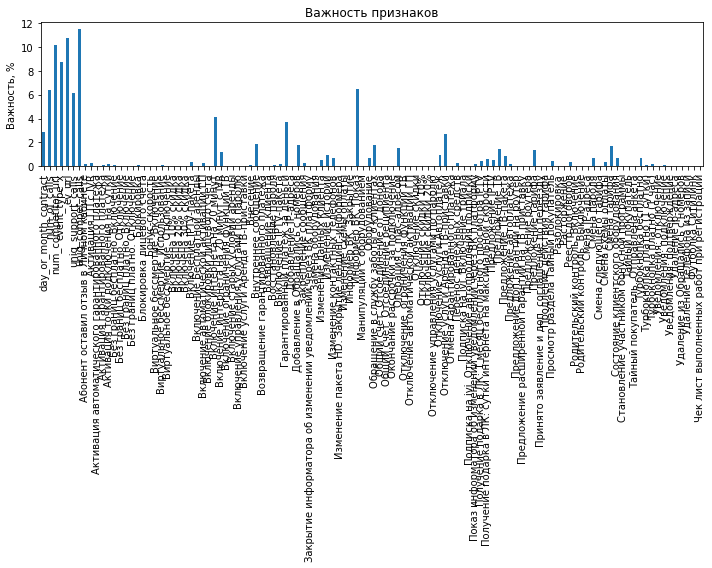

In [151]:
# визуализируем важность признаков
cat_iris_imp = pd.Series(cbc.get_feature_importance(),
                         df_full.drop(["blocked", 'contract_id'], axis = 1).columns)
fig, ax = plt.subplots(figsize=(10,8))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [152]:
feat_imp = pd.Series(cbc.get_feature_importance(), df_full.drop(["blocked", 'contract_id'], axis = 1).columns)
feat_imp = feat_imp[feat_imp>1].index

In [153]:
feat_imp

Index(['day_or_month_contract', 'num_of_calls', 'num_competitor_url',
       'event_type_x', 'ev_url', 'uniq_support_calls', 'uniq_compet_calls',
       'Включение интернета на 20 минут',
       'Включение интернета на 20 минут с IVR', 'Внутреннее сообщение',
       'Гарантированный платеж за деньги', 'Добавление в Обращались с номеров',
       'Информер ВК. Показ', 'Обращение в службу заботы о клиентах',
       'Операция с mac-адресом', 'Отключение услуги Аренда ТВ-приставки',
       'Предложение ТВ', 'Предложение тарифа', 'Смена тарифа'],
      dtype='object')

In [154]:
cbc.fit(X_train[feat_imp], y_train)

## Оценка точности

In [155]:
pred_cbc = cbc.predict(X_test[feat_imp])
print("Recall score:", recall_score(y_test, pred_cbc, average='macro'))

Recall score: 0.7822046510334084


# Получение тестовой выборки

In [159]:
df_sample_solution = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/karelia/sample_solution.csv') 
un_type = df_type_contract.groupby("contract_id").agg('last')
df_sample_solution = pd.merge(df_sample_solution, un_type , on="contract_id", how='left')
df_sample_solution = pd.merge(df_sample_solution, count_log , on="contract_id", how='left').drop(["event_date"],axis =1).rename(columns={'event_type':'num_of_calls'})
df_sample_solution = pd.merge(df_sample_solution, count_named , on="contract_id", how='left').drop(["date"],axis =1).rename(columns={'url':'num_competitor_url'})

In [160]:
last_log = df_log.groupby('contract_id').agg('last')
df_sample_solution = pd.merge(df_sample_solution, last_log , on="contract_id", how='left').drop(["event_date"],axis =1)
df_sample_solution = df_sample_solution.fillna(0)
df_sample_solution[['day_or_month_contract', 'num_of_calls', 'num_competitor_url']] = df_sample_solution[['day_or_month_contract', 'num_of_calls', 'num_competitor_url']].astype('int')

In [161]:
# Расчёт соотношения обращений к конкурентам на обно обращение в службу поддержки
df_sample_solution['ev_url'] = df_sample_solution['num_competitor_url']  / df_sample_solution['num_of_calls']
df_sample_solution['ev_url'] = df_sample_solution['ev_url'].fillna(-1)

In [162]:
# расчитаю суммарное количество уникальных обращений в поддержку
df_sample_solution = pd.merge(df_sample_solution, n_un_log , on="contract_id", how='left').rename(columns={'event_type_y':'uniq_support_calls'})

In [163]:
# расчитаю суммарное количество уникальных обращений к конкурентам
df_sample_solution = pd.merge(df_sample_solution, n_un_url , on="contract_id", how='left').rename(columns={'url':'uniq_compet_calls'})

In [164]:
p = pd.pivot_table(df_log, index = 'contract_id', columns = 'event_type', values = 'event_date', aggfunc='count')

In [165]:
df_sample_solution = pd.merge(df_sample_solution, p , on="contract_id", how='left')

In [166]:
df_sample_solution = df_sample_solution.fillna(0)

# Предсказание

In [42]:
from sklearn.utils import shuffle

In [131]:
features = df_bal.drop(["blocked", 'contract_id'], axis = 1)
target = df_bal[["blocked"]]

In [156]:
features = df_bal[feat_imp]
target = df_bal[["blocked"]]

In [93]:
features[cat_feat].isna().sum()

event_type_x    0
dtype: int64

In [ ]:
cbc = cb.CatBoostClassifier(random_state = 12345, cat_features = cat_feat)
cbc.fit(features, target)

In [168]:
features_test = df_sample_solution[feat_imp]

In [135]:
features_test = df_sample_solution.drop(["blocked", 'contract_id'], axis = 1)

In [169]:
df_sample_solution["blocked"] = cbc.predict(features_test)

In [171]:
df_sample_solution = df_sample_solution[['contract_id','blocked']]

In [172]:
df_sample_solution.to_csv("/content/submission_10.csv", index= False)